## **Prediksi Harga Bitcoin Menggunakan Deeo Learning**

- **Nama:** I Made Bagus Wahyu Mahendra
- **Email:** theybagus71@gmail.com
- **ID Dicoding:** baguswahyu77

## Import Library

In [ ]:
pip install yfinance

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

## Data Loading

In [ ]:
# Load data
end = datetime.now()
start = datetime(end.year-10, end.month, end.day)
stock = "BTC-USD"
df = yf.download(stock, start, end)


[*********************100%***********************]  1 of 1 completed


## Exploratory Data Analysis (EDA)
### Deskripsi Variabel:
- Date: Tanggal pencatatan harga Bitcoin.
- Open: Harga pembukaan Bitcoin.
- High: Harga tertinggi dalam satu hari.
- Low: Harga terendah dalam satu hari.
- Close: Harga penutupan Bitcoin (digunakan sebagai target prediksi).
- Volume: Volume perdagangan Bitcoin dalam satu hari.


In [ ]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2015-02-12,221.764008,222.199005,217.613998,219.207993,15206200
2015-02-13,235.427002,240.259003,221.261993,221.968994,42744400
2015-02-14,257.321014,259.808014,235.528000,235.528000,49732500
2015-02-15,234.824997,265.610992,227.684006,257.506989,56552400
2015-02-16,233.843002,239.520996,229.022003,234.824997,28153700


In [ ]:
df.shape

(3654, 5)

In [ ]:
df.describe()

Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
count,3654.000000,3654.000000,3654.000000,3654.000000,3.654000e+03
mean,21303.776778,21754.802054,20783.129091,21278.850396,1.973536e+10
std,23677.371481,24160.421580,23123.659521,23649.390619,2.077232e+10
min,210.494995,222.199005,199.567001,210.067993,1.060090e+07
25%,3379.524963,3457.360413,3249.033203,3348.935059,1.539302e+09
50%,10055.251953,10233.897949,9724.194824,10031.268555,1.614006e+10
75%,34641.250000,35358.779297,33487.074219,34588.490234,3.077109e+10
max,106146.265625,109114.882812,105291.734375,106147.296875,3.509679e+11


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3654 entries, 2015-02-12 to 2025-02-12
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BTC-USD)   3654 non-null   float64
 1   (High, BTC-USD)    3654 non-null   float64
 2   (Low, BTC-USD)     3654 non-null   float64
 3   (Open, BTC-USD)    3654 non-null   float64
 4   (Volume, BTC-USD)  3654 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 171.3 KB


### Menangani Missing Value dan Outlier pada Dataset

In [ ]:
df.isna().sum()

,,0
Price,Ticker,
Close,BTC-USD,0
High,BTC-USD,0
Low,BTC-USD,0
Open,BTC-USD,0
Volume,BTC-USD,0


Dari hasil di atas, tidak terdapat Missing Value pada setiap variabel

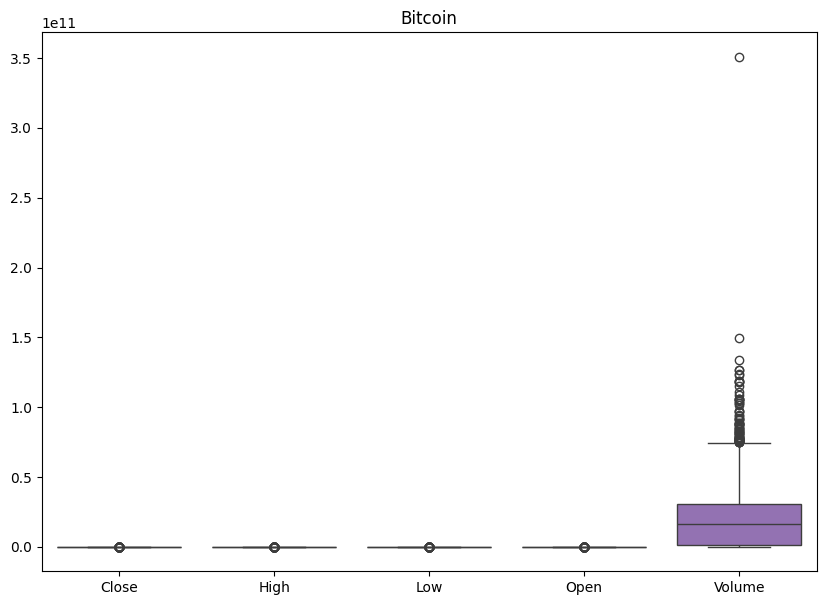

In [ ]:
plt.subplots(figsize=(10,7))
sns.boxplot(data=df).set_title("Bitcoin")
plt.show()

Karena Bitcoin dikenal memiliki volatilitas harga yang tinggi. Lonjakan harga atau volume yang ekstrem sering kali mencerminkan sentimen pasar, pengaruh berita besar, atau aktivitas institusional. Menghapus outlier dapat menghilangkan informasi penting yang bisa membantu model dalam memprediksi tren harga di masa depan, maka dari itu outlier pada dataset tidak dihapus.

### Univariate Analysis for Numerical Features


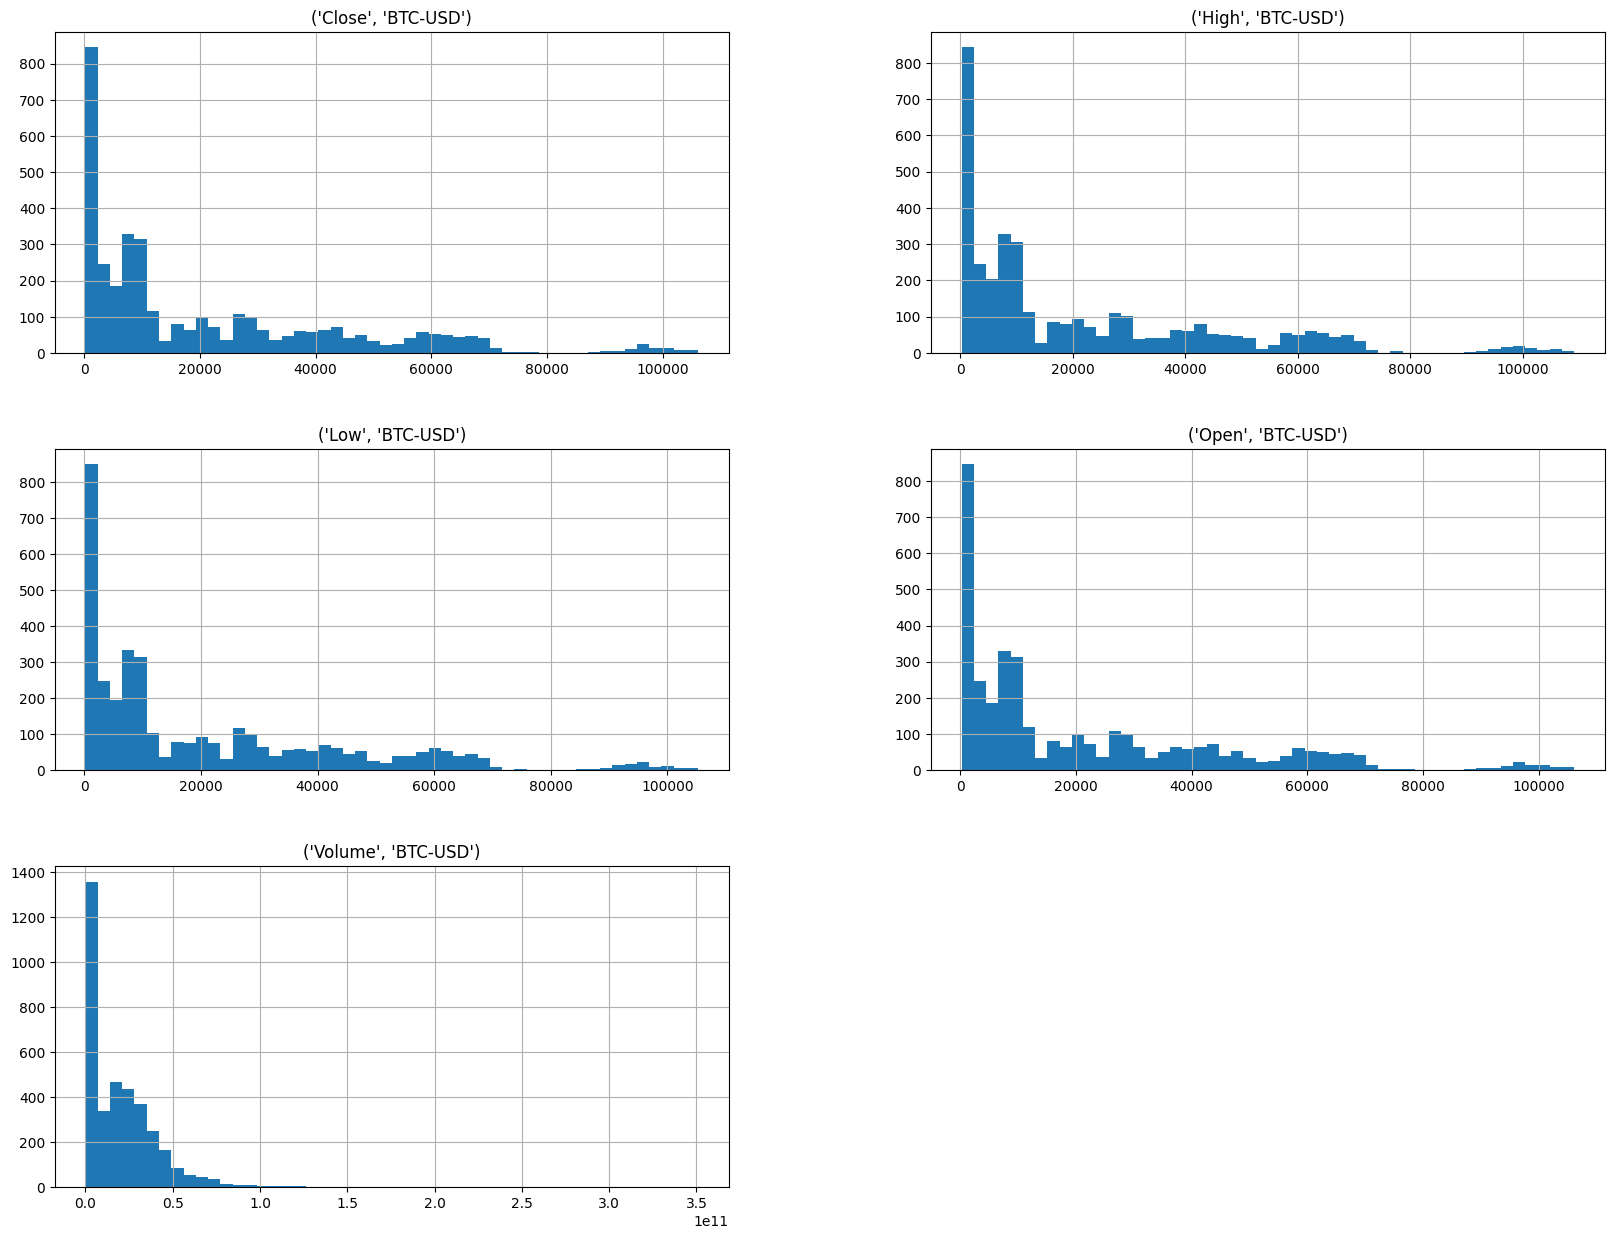

In [ ]:
df.hist(bins=50, figsize=(20,15))
plt.show()

Berdasarkan histogram di atas, kita mendapatkan beberapa informasi, antara lain:
- Semua fitur harga Bitcoin (Open, High, Low, Close) dan Volume menunjukkan distribusi yang condong ke kiri (positively skewed).
- Sebagian besar data harga Bitcoin berada di bawah 20.000 USD, dengan frekuensi tinggi pada nilai yang lebih rendah. Ini menunjukkan bahwa harga Bitcoin lebih sering berada di kisaran rendah dibandingkan harga tertinggi yang jarang terjadi.
- Histogram volume menunjukkan rentang nilai yang luas, dengan sebagian besar transaksi terjadi pada volume yang relatif kecil, tetapi ada beberapa lonjakan volume yang sangat tinggi.

### Multivariate Analysis for Numerical Features

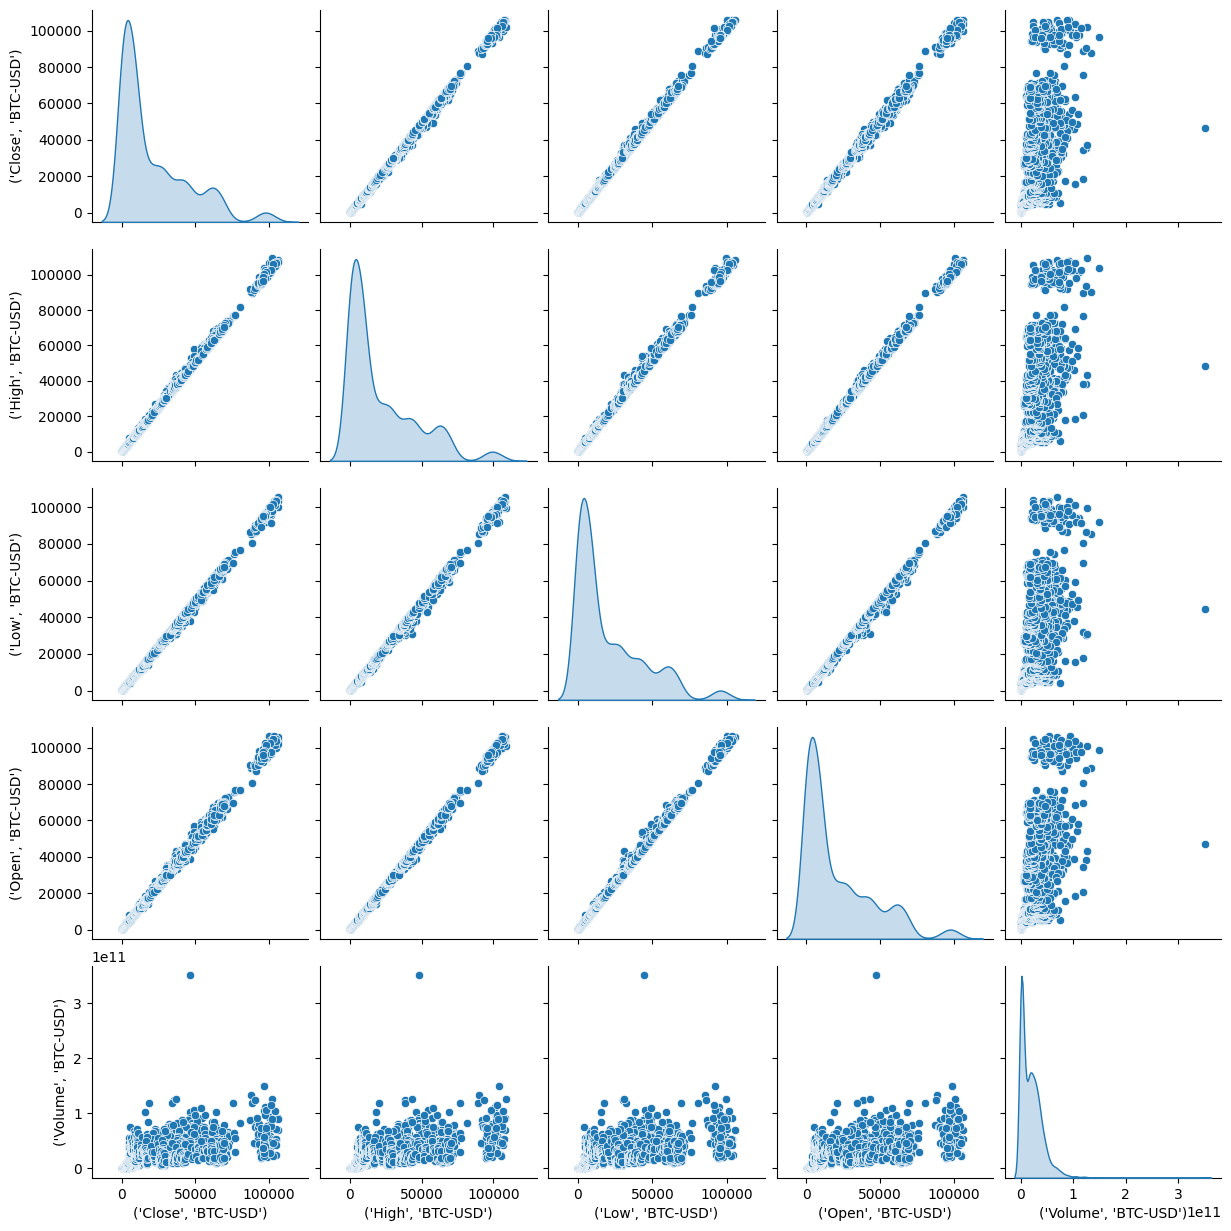

In [ ]:
sns.pairplot(df, diag_kind = 'kde')

Berdasarkan hasil pair plot di atas, informasi yang kita dapat antara lain:
- Hubungan Linier Kuat antara Open, High, Low, dan Close
- Volume memiliki hubungan yang lebih variatif
- Histogram diagonal menunjukkan bahwa distribusi data cenderung skewed ke kiri (positively skewed), dengan sebagian besar nilai berada pada kisaran rendah.

### Korelasi Antar Fitur

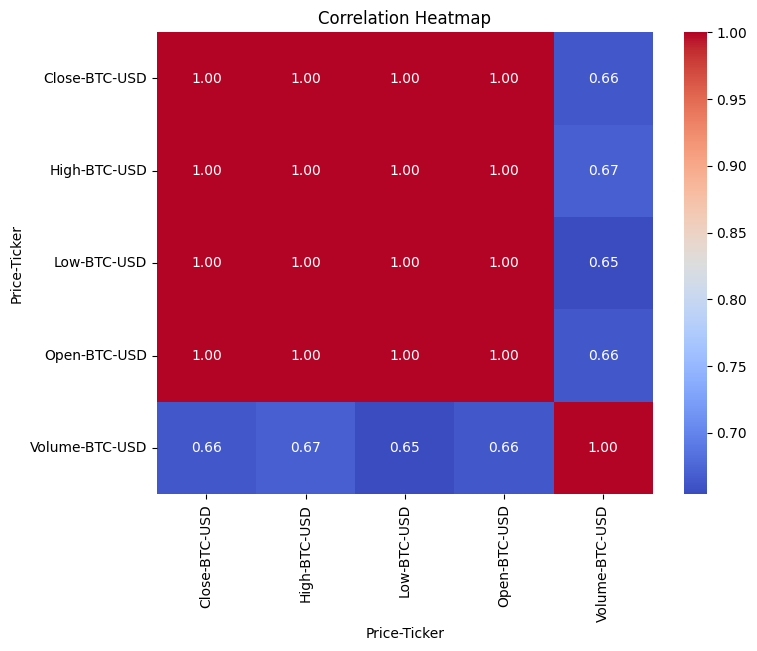

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Heatmap di atas menunjukkan korelasi antara berbagai fitur dalam dataset harga Bitcoin. Terlihat bahwa Close, High, Low, dan Open BTC-USD memiliki korelasi sempurna (1.00), menandakan bahwa harga-harga ini bergerak bersamaan. Volume BTC-USD memiliki korelasi sekitar 0.65-0.67 dengan harga, menunjukkan hubungan yang cukup kuat tetapi tidak sebesar fitur harga lainnya.

### Analisis Trend Grafik Harga Bitcoin

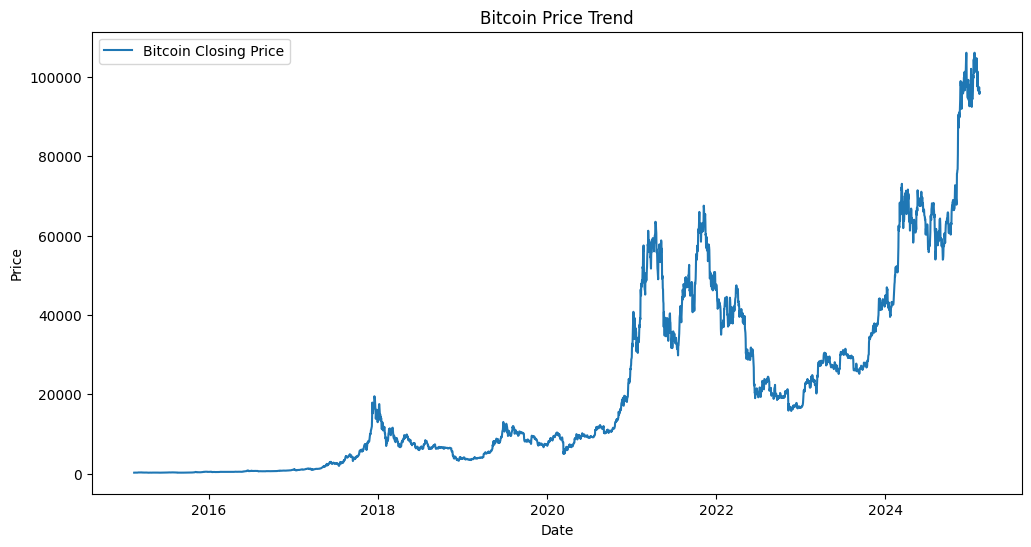

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label='Bitcoin Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin Price Trend')
plt.legend()
plt.show()

Grafik di atas menunjukkan tren harga Bitcoin dari tahun 2015 hingga 2024, dengan sumbu horizontal merepresentasikan waktu dan sumbu vertikal menunjukkan harga dalam satuan USD. Dari grafik, terlihat bahwa harga Bitcoin mengalami volatilitas tinggi dengan beberapa lonjakan signifikan, terutama pada tahun 2017, 2021, dan 2024. Peningkatan harga yang tajam diikuti oleh koreksi yang cukup besar mencerminkan sifat spekulatif pasar kripto. Tren kenaikan jangka panjang menunjukkan bahwa meskipun mengalami fluktuasi besar, Bitcoin cenderung mengalami apresiasi nilai seiring waktu.

In [ ]:
def plot_graph(figsize, values, column_name):
    plt.figure(figsize=figsize)
    values.plot()
    plt.xlabel("Years")
    plt.ylabel(column_name)
    plt.title(f"{column_name} of Bitcoin")
    plt.show()


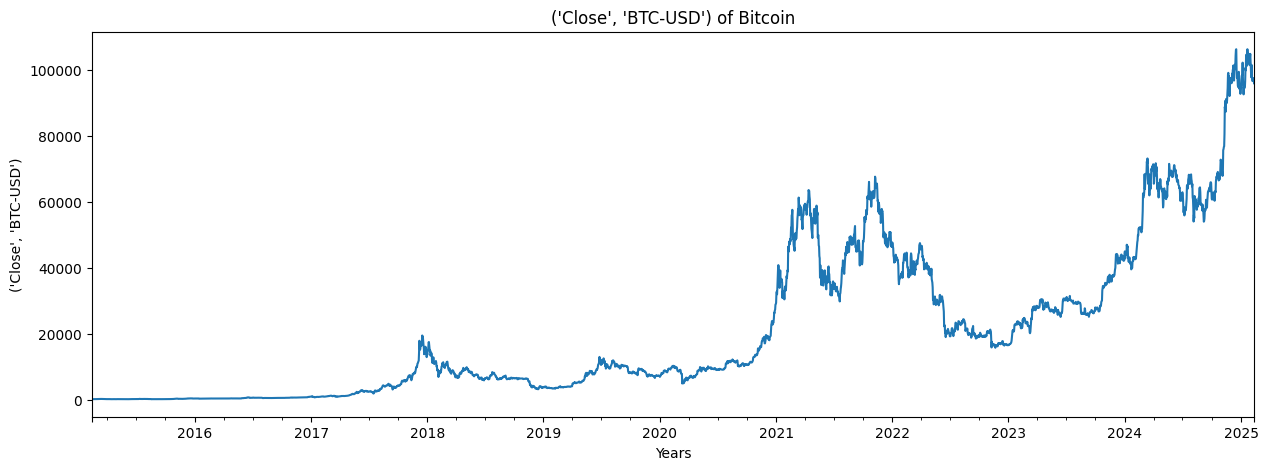

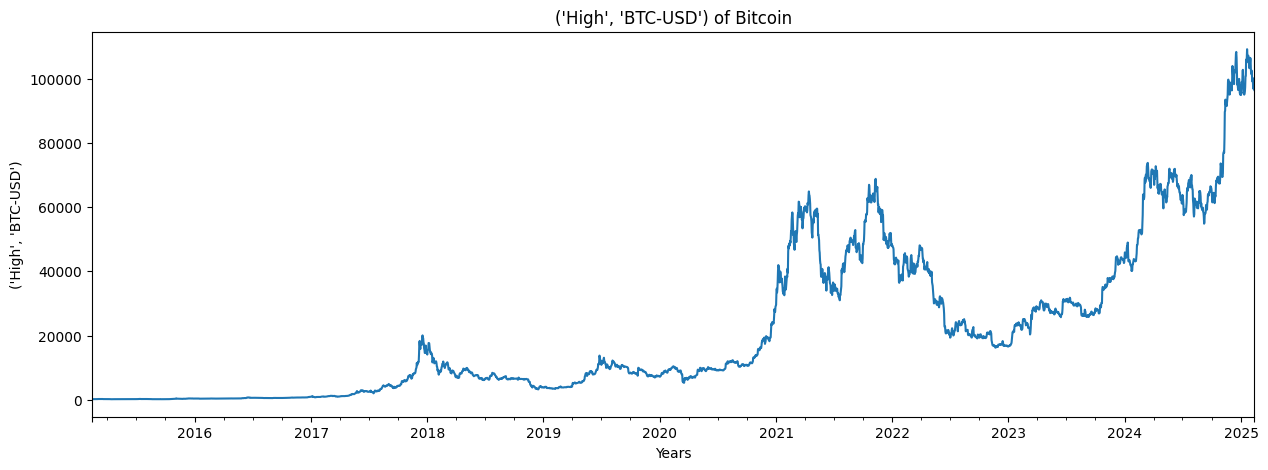

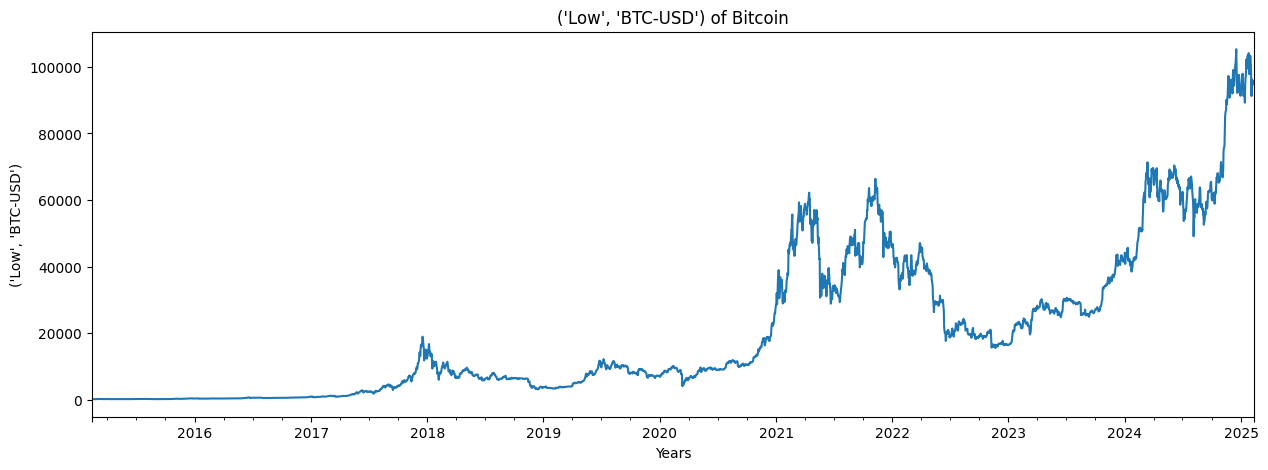

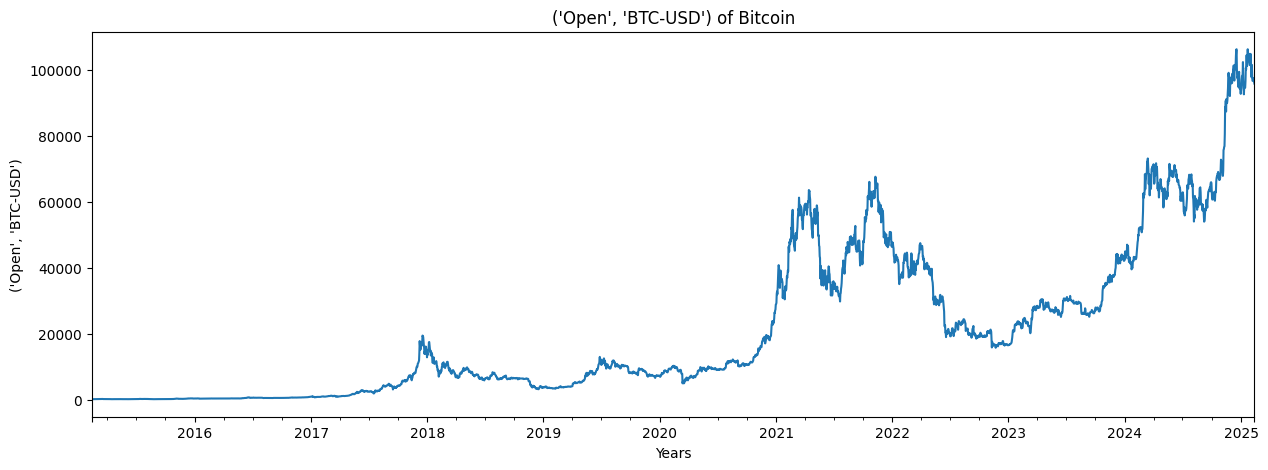

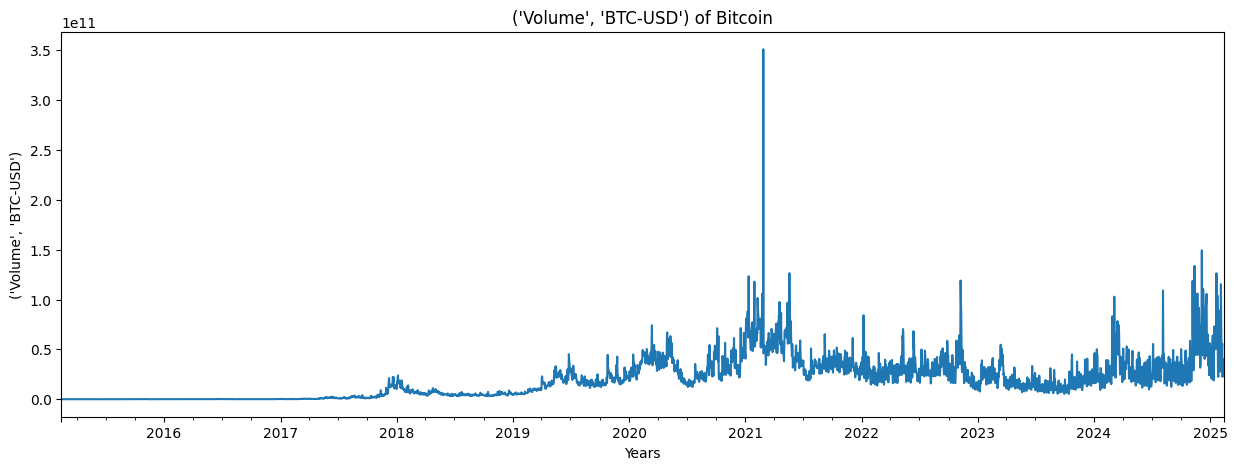

In [ ]:
for column in df.columns:
    plot_graph((15,5),df[column], column)

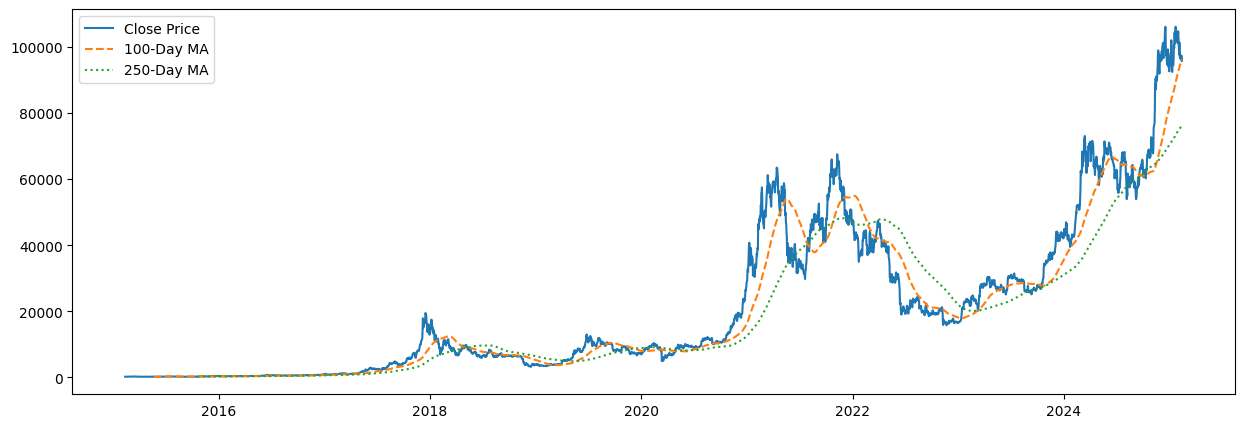

In [ ]:
# Moving Average
df['MA_100'] = df['Close'].rolling(100).mean()
df['MA_250'] = df['Close'].rolling(250).mean()
plt.figure(figsize=(15,5))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['MA_100'], label='100-Day MA', linestyle='dashed')
plt.plot(df['MA_250'], label='250-Day MA', linestyle='dotted')
plt.legend()
plt.show()

Grafik di atas menampilkan pergerakan harga Bitcoin dengan tambahan indikator Moving Average (MA) 100-hari dan 250-hari, yang ditampilkan sebagai garis putus-putus berwarna oranye dan hijau. Indikator MA membantu mengidentifikasi tren pasar dengan meratakan fluktuasi harga jangka pendek, di mana MA 100-hari lebih responsif terhadap perubahan dibandingkan MA 250-hari yang lebih stabil. Ketika harga Bitcoin berada di atas MA, ini sering mengindikasikan tren bullish, sementara jika berada di bawah MA, ini dapat menjadi sinyal bearish. Analisis MA penting dalam memprediksi harga Bitcoin karena membantu mengurangi noise pasar, memberikan gambaran tren yang lebih jelas, serta digunakan untuk mendeteksi potensi titik masuk dan keluar yang lebih strategis dalam perdagangan kripto.

## Data Preparation

In [ ]:
# Normalization
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df[['Close']])

In [ ]:
# Prepare dataset for LSTM
x_data, y_data = [], []
for i in range(100, len(scaled_data)):
    x_data.append(scaled_data[i-100:i])
    y_data.append(scaled_data[i])

x_data, y_data = np.array(x_data), np.array(y_data)

In [ ]:
# Split dataset
split_len = int(len(x_data) * 0.8)
x_train, y_train = x_data[:split_len], y_data[:split_len]
x_test, y_test = x_data[split_len:], y_data[split_len:]

## Build Model

### Long Short Term Memory (LSTM) Model

In [ ]:
# Build LSTM Model
lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(64, return_sequences=False),
    Dense(25),
    Dense(1)
])

lstm_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 128)            │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,625 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 117,619 (459.45 KB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(x_train, y_train, batch_size=1, epochs=3, verbose=1)

Epoch 1/3
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - loss: 8.8501e-04
Epoch 2/3
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - loss: 2.4567e-04
Epoch 3/3
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - loss: 2.8618e-04


### Gated Recurrent Unit (GRU)

In [ ]:
# Build GRU Model
gru_model = Sequential([
    GRU(128, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    GRU(64, return_sequences=False),
    Dense(25),
    Dense(1)
])

gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 100, 128)            │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │           1,625 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,203 (348.45 KB)

 Trainable params: 89,203 (348.45 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
gru_model.compile(optimizer='adam', loss='mean_squared_error')
gru_model.fit(x_train, y_train, batch_size=1, epochs=3, verbose=1)

Epoch 1/3
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - loss: 7.0661e-04
Epoch 2/3
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - loss: 2.3015e-04
Epoch 3/3
2843/2843 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - loss: 2.0268e-04


In [ ]:
# Predictions
lstm_predictions = lstm_model.predict(x_test)
gru_predictions = gru_model.predict(x_test)

inv_lstm_predictions = scaler.inverse_transform(lstm_predictions)
inv_gru_predictions = scaler.inverse_transform(gru_predictions)
inv_y_test = scaler.inverse_transform(y_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


## Model Evaluation

In [ ]:
# Evaluation Metrics
lstm_rmse = np.sqrt(np.mean((inv_lstm_predictions - inv_y_test)**2))
lstm_mae = mean_absolute_error(inv_y_test, inv_lstm_predictions)
lstm_r2 = r2_score(inv_y_test, inv_lstm_predictions)

gru_rmse = np.sqrt(np.mean((inv_gru_predictions - inv_y_test)**2))
gru_mae = mean_absolute_error(inv_y_test, inv_gru_predictions)
gru_r2 = r2_score(inv_y_test, inv_gru_predictions)

In [ ]:
print("LSTM Metrics:")
print(f"RMSE: {lstm_rmse}")
print(f"MAE: {lstm_mae}")
print(f"R-squared: {lstm_r2}")

print("\nGRU Metrics:")
print(f"RMSE: {gru_rmse}")
print(f"MAE: {gru_mae}")
print(f"R-squared: {gru_r2}")

LSTM Metrics:
RMSE: 2328.3901691466535
MAE: 1905.0201191104081
R-squared: 0.9902783309220354

GRU Metrics:
RMSE: 1752.9421325001797
MAE: 1177.4048243011603
R-squared: 0.9944898365843421


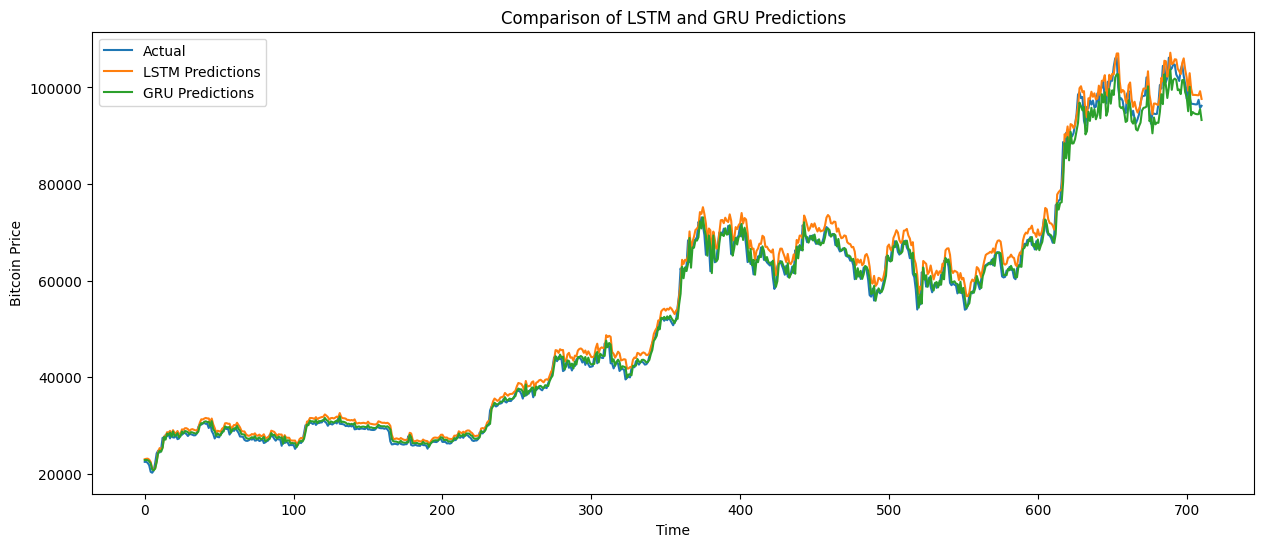

In [ ]:
# Plot Results
plt.figure(figsize=(15,6))
plt.plot(inv_y_test, label='Actual')
plt.plot(inv_lstm_predictions, label='LSTM Predictions')
plt.plot(inv_gru_predictions, label='GRU Predictions')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.title('Comparison of LSTM and GRU Predictions')
plt.legend()
plt.show()

In [ ]:
# Predict Future Price with GRU model
last_100_days = scaled_data[-100:].reshape(1, 100, 1)
future_price_scaled = gru_model.predict(last_100_days)
future_price = scaler.inverse_transform(future_price_scaled)

print(f"Predicted Bitcoin Closing Price: {future_price[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Bitcoin Closing Price: 94537.140625


### Conclusion
Model prediksi harga Bitcoin menggunakan Deep Learning telah dievaluasi dengan dua jenis arsitektur jaringan saraf, yaitu LSTM dan GRU. Dari hasil tersebut, GRU menunjukkan performa yang lebih baik dibandingkan LSTM dalam hal:

- Error lebih rendah → RMSE dan MAE pada GRU lebih kecil dibandingkan LSTM, yang berarti prediksi harga Bitcoin menggunakan GRU lebih akurat.
- R-squared lebih tinggi → Nilai R² pada GRU lebih tinggi dibandingkan LSTM (0.9946 vs 0.9923), yang menunjukkan bahwa model GRU lebih mampu menjelaskan variabilitas data harga Bitcoin.

Berdasarkan hasil evaluasi, model GRU lebih direkomendasikan untuk digunakan dalam prediksi harga Bitcoin karena:

✅ Memiliki akurasi lebih tinggi (error lebih kecil dan R² lebih besar).

✅ Lebih ringan secara komputasi dibandingkan LSTM.

✅ Cocok untuk dataset dengan urutan panjang seperti time series.